# Generate Time Series

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import tensorflow.keras as keras



# Create time series - number of time series = batch size
# n_steps = number of steps
# freq and offsets - randomly generated and used in the sinusoidal function

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # noise
    return series[:, np.newaxis].astype(np.float32).reshape(batch_size, n_steps,1)


<AxesSubplot:>

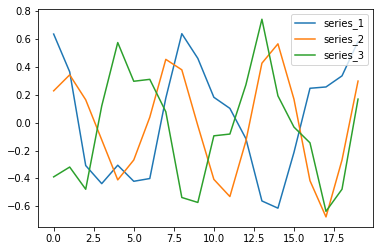

In [2]:
# Let us try to visualise the time series, for simplicity sake just look at 3 stime series
# generate sample 

batch_size = 3
s = generate_time_series(batch_size, 20)

times_df = pd.DataFrame(s.reshape(batch_size,-1)).T
times_df.columns= ['series_' + str(x) for x in range(1,batch_size + 1)]
times_df.plot.line()



# Modelling 

In [3]:
# We will randomly generate 10000 series
# You can think of this as time series of 10000 stocks (We will be actually doing that too)
# X_Train contains 7000 time series of shape 7000,50,1
# X_Valid contains 2000 time series
# X_Test contains 1000 time series 

# X is the first n_steps and we are trying to predict n+1 step
# Y is a column vector, the 51st step -> -1 implies select last column

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

### Baseline Metrics

In [4]:
# Naive - the last value of X_valid

y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020707076

In [6]:
import tensorflow as tf
# simple RNN 

model = keras.models.Sequential([
keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(1e-4), metrics = ['RootMeanSquaredError'])

history = model.fit(x=X_train, y=y_train, batch_size=32,epochs=15, validation_data=(X_valid, y_valid))

Epoch 1/15
219/219 [==============================] - 4s 6ms/step - loss: 1.0460 - root_mean_squared_error: 1.0227 - val_loss: 1.0802 - val_root_mean_squared_error: 1.0393
Epoch 2/15
219/219 [==============================] - 1s 5ms/step - loss: 1.0375 - root_mean_squared_error: 1.0186 - val_loss: 1.0718 - val_root_mean_squared_error: 1.0353
Epoch 3/15
219/219 [==============================] - 1s 5ms/step - loss: 1.0284 - root_mean_squared_error: 1.0141 - val_loss: 1.0628 - val_root_mean_squared_error: 1.0309
Epoch 4/15
219/219 [==============================] - 1s 5ms/step - loss: 1.0186 - root_mean_squared_error: 1.0093 - val_loss: 1.0532 - val_root_mean_squared_error: 1.0263
Epoch 5/15
219/219 [==============================] - 1s 5ms/step - loss: 1.0080 - root_mean_squared_error: 1.0040 - val_loss: 1.0428 - val_root_mean_squared_error: 1.0212
Epoch 6/15
219/219 [==============================] - 1s 5ms/step - loss: 0.9964 - root_mean_squared_error: 0.9982 - val_loss: 1.0314 - val_

In [7]:
# benchmark mse
y_pred = model.predict(X_valid)
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.83638877

In [8]:
y_pred = model.predict(X_test)
np.mean(keras.losses.mean_squared_error(y_test, y_pred))

0.8423383

# Deep RNN

In [9]:
# since multiple layers, we can run for more epochs 

model = keras.models.Sequential([
keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,
1]),
keras.layers.SimpleRNN(20, return_sequences=True),
keras.layers.SimpleRNN(1)
])

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(1e-4), metrics = ['mean_squared_error'])

history = model.fit(x=X_train, y=y_train, batch_size=32,epochs=50, validation_data=(X_valid, y_valid))

Epoch 1/50
219/219 [==============================] - 6s 17ms/step - loss: 0.3081 - mean_squared_error: 0.3081 - val_loss: 0.0742 - val_mean_squared_error: 0.0742
Epoch 2/50
219/219 [==============================] - 3s 15ms/step - loss: 0.0473 - mean_squared_error: 0.0473 - val_loss: 0.0295 - val_mean_squared_error: 0.0295
Epoch 3/50
219/219 [==============================] - 3s 15ms/step - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
Epoch 4/50
219/219 [==============================] - 3s 15ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 5/50
219/219 [==============================] - 3s 15ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 6/50
219/219 [==============================] - 3s 15ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 7/50
219/219 [==

In [10]:
# benchmark mse
y_pred = model.predict(X_valid)
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.0031656942

In [11]:
y_pred = model.predict(X_test)
np.mean(keras.losses.mean_squared_error(y_test, y_pred))

0.0032122931

## Forecasting ahead

### method 1 : Treat the new x_pred as input and output the next step recursively


In [25]:
# forecast is the number of steps we want to forecast ahead
# Generate X_new and Y_new for 3000 time series, like validation set above

forecast = 10
series = generate_time_series(3000, n_steps + forecast)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(forecast):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)
Y_pred = X[:, n_steps:]

In [26]:
# The error seems way too high, because this is cumulative error for 50 steps as compared to only 1 step previously

np.mean(keras.losses.mean_squared_error(Y_new, Y_pred))

0.14289214

<AxesSubplot:>

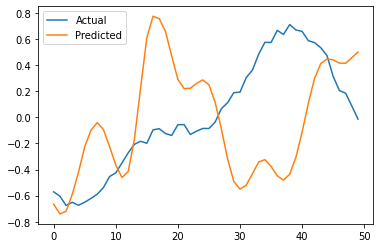

In [13]:
# As we can see, errors keep accumulating, after step 10 pretty poor output

times_df = pd.DataFrame(np.hstack((Y_new.reshape(-1, 1), Y_pred.reshape(-1, 1))), columns = ['Actual','Predicted'])

times_df.plot.line()

### Method 2: Use sequence to vector model

Predict all 50 values at once

In [28]:
# now Y is not a column vector, it consists of all forecasted outputs

forecast = 10
series = generate_time_series(10000, n_steps + forecast)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -forecast:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -forecast:,0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -forecast:, 0]


In [29]:
Y_train.shape

(7000, 10)

In [30]:
model = keras.models.Sequential([
keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,
1]),
keras.layers.SimpleRNN(20),
keras.layers.Dense(forecast)
])

In [31]:
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(1e-4), metrics = ['mean_squared_error'])

history = model.fit(x=X_train, y=Y_train, batch_size=32,epochs=50, validation_data=(X_valid, Y_valid))

Epoch 1/50
219/219 [==============================] - 4s 11ms/step - loss: 0.1583 - mean_squared_error: 0.1583 - val_loss: 0.1001 - val_mean_squared_error: 0.1001
Epoch 2/50
219/219 [==============================] - 2s 10ms/step - loss: 0.0839 - mean_squared_error: 0.0839 - val_loss: 0.0692 - val_mean_squared_error: 0.0692
Epoch 3/50
219/219 [==============================] - 2s 10ms/step - loss: 0.0606 - mean_squared_error: 0.0606 - val_loss: 0.0547 - val_mean_squared_error: 0.0547
Epoch 4/50
219/219 [==============================] - 2s 10ms/step - loss: 0.0511 - mean_squared_error: 0.0511 - val_loss: 0.0495 - val_mean_squared_error: 0.0495
Epoch 5/50
219/219 [==============================] - 2s 10ms/step - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0461 - val_mean_squared_error: 0.0461
Epoch 6/50
219/219 [==============================] - 2s 10ms/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0426 - val_mean_squared_error: 0.0426
Epoch 7/50
219/219 [==

In [34]:
# benchmark mse
y_pred = model.predict(X_valid)
np.mean(keras.losses.mean_squared_error(Y_valid, y_pred))

0.011009066

In [35]:
y_pred = model.predict(X_test)
np.mean(keras.losses.mean_squared_error(Y_test, y_pred))

0.01161295

### Method 3 : Treating Y as a sequence

In [36]:
# forecast_steps is the number of steps you want to forecast ahead, and in this case also the steps ahead you want for y at each step 
forecast_steps = 10
Y = np.empty((10000, n_steps, forecast_steps)) # each target is a sequence of 10D vectors
for step_ahead in range(1, forecast_steps + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps,0]
    Y_train = Y[:7000]
    Y_valid = Y[7000:9000]
    Y_test = Y[9000:]

In [42]:
print(Y_train.shape)
print(Y_valid.shape)
print(Y_test.shape)

(7000, 50, 10)
(2000, 50, 10)
(1000, 50, 10)


In [38]:
# only the last output is used for evaluation (the other outputs are used for training)
Y_test[:, -1].shape

(1000, 10)

In [43]:
model = keras.models.Sequential([
keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,
1]),
keras.layers.SimpleRNN(20, return_sequences=True),
keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(x=X_train, y=Y_train, batch_size=32,epochs=100, validation_data=(X_valid, Y_valid))

Epoch 1/100
219/219 [==============================] - 4s 11ms/step - loss: 0.0516 - last_time_step_mse: 0.0401 - val_loss: 0.0401 - val_last_time_step_mse: 0.0260
Epoch 2/100
219/219 [==============================] - 2s 10ms/step - loss: 0.0372 - last_time_step_mse: 0.0238 - val_loss: 0.0317 - val_last_time_step_mse: 0.0169
Epoch 3/100
219/219 [==============================] - 2s 10ms/step - loss: 0.0314 - last_time_step_mse: 0.0181 - val_loss: 0.0299 - val_last_time_step_mse: 0.0171
Epoch 4/100
219/219 [==============================] - 2s 10ms/step - loss: 0.0278 - last_time_step_mse: 0.0139 - val_loss: 0.0266 - val_last_time_step_mse: 0.0125
Epoch 5/100
219/219 [==============================] - 2s 10ms/step - loss: 0.0260 - last_time_step_mse: 0.0123 - val_loss: 0.0261 - val_last_time_step_mse: 0.0124
Epoch 6/100
219/219 [==============================] - 2s 10ms/step - loss: 0.0246 - last_time_step_mse: 0.0114 - val_loss: 0.0234 - val_last_time_step_mse: 0.0105
Epoch 7/100
219/

In [51]:
# benchmark mse
y_pred = model.predict(X_valid)
np.mean(last_time_step_mse(Y_valid, y_pred))

0.006343851

In [52]:
y_pred = model.predict(X_test)
np.mean(last_time_step_mse(Y_test, y_pred))

0.005994712